# Preprocessing

In [ ]:
!wget https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py ./
!pip install mxnet

In [2]:
!aws s3 cp --recursive s3://easy-ml-pocs/pneumonia-image-data/ ./data/

download: s3://easy-ml-pocs/pneumonia-image-data/normal/IM-0530-0001.jpeg to data/normal/IM-0530-0001.jpeg
download: s3://easy-ml-pocs/pneumonia-image-data/normal/IM-0528-0001.jpeg to data/normal/IM-0528-0001.jpeg
download: s3://easy-ml-pocs/pneumonia-image-data/normal/IM-0532-0001.jpeg to data/normal/IM-0532-0001.jpeg
download: s3://easy-ml-pocs/pneumonia-image-data/normal/IM-0529-0001.jpeg to data/normal/IM-0529-0001.jpeg
download: s3://easy-ml-pocs/pneumonia-image-data/normal/IM-0531-0001-0001.jpeg to data/normal/IM-0531-0001-0001.jpeg
download: s3://easy-ml-pocs/pneumonia-image-data/normal/IM-0531-0001.jpeg to data/normal/IM-0531-0001.jpeg
download: s3://easy-ml-pocs/pneumonia-image-data/normal/IM-0533-0001-0002.jpeg to data/normal/IM-0533-0001-0002.jpeg
download: s3://easy-ml-pocs/pneumonia-image-data/normal/IM-0533-0001-0001.jpeg to data/normal/IM-0533-0001-0001.jpeg
download: s3://easy-ml-pocs/pneumonia-image-data/normal/IM-0534-0001.jpeg to data/normal/IM-0534-0001.jpeg
downloa

In [3]:
!python im2rec.py ./data_rec ./data/ --recursive --list --num-thread 8 --test-ratio=0.3 --train-ratio=0.7


normal 0
pneumonia 1


In [4]:
!ls

data		   data_rec_test.rec   data_rec_train.rec  prep data.ipynb
data_rec_test.idx  data_rec_train.idx  im2rec.py
data_rec_test.lst  data_rec_train.lst  im2rec.py.1


In [5]:
!python im2rec.py ./data_rec ./data/ --recursive --pass-through --pack-label --num-thread 8

Creating .rec file from /home/ec2-user/SageMaker/sm easy image classification/data_rec_train.lst in /home/ec2-user/SageMaker/sm easy image classification
time: 0.07957172393798828  count: 0
time: 0.6292400360107422  count: 1000
Creating .rec file from /home/ec2-user/SageMaker/sm easy image classification/data_rec_test.lst in /home/ec2-user/SageMaker/sm easy image classification
time: 0.03711295127868652  count: 0


In [16]:
!wc -l data_rec_train.lst

1358 data_rec_train.lst


## upload to S3

In [9]:
import sagemaker
sess = sagemaker.Session()

trainpath = sess.upload_data(
    path='data_rec_train.rec', bucket='easy-ml-pocs',
    key_prefix='sagemaker/pneumonia-image-data/input')

testpath = sess.upload_data(
    path='data_rec_test.rec', bucket='easy-ml-pocs',
    key_prefix='sagemaker/pneumonia-image-data/input')

# Training

In [10]:
trainpath

's3://easy-ml-pocs/sagemaker/pneumonia-image-data/input/data_rec_train.rec'

In [11]:
testpath

's3://easy-ml-pocs/sagemaker/pneumonia-image-data/input/data_rec_test.rec'

In [17]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = "18" 
# we need to specify the input image shape for the training data
image_shape = "3,1000,1000"
# we also need to specify the number of training samples in the training set
# for caltech it is 15420
num_training_samples = "1358"
# specify the number of output classes
num_classes = "2"
# batch size for training
mini_batch_size =  "64"
# number of epochs
epochs = "2"
# learning rate
learning_rate = "0.01"

In [22]:
%%time
import time
import boto3
from time import gmtime, strftime
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role

role = get_execution_role()

bucket='easy-ml-pocs' # customize to your bucket

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

s3 = boto3.client('s3')
# create unique job name 
job_name = 'DEMO-imageclassification-' + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/sagemaker/{}/output'.format(bucket, 'DEMO-imageclassification-')
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p3.16xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": trainpath,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": testpath,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: DEMO-imageclassification--2020-03-26-16-49-59

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://easy-ml-pocs/sagemaker/pneumonia-image-data/input/data_rec_train.rec', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 85.5 ms, sys: 0 ns, total: 85.5 ms
Wall time: 134 ms


In [23]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


# Create model

In [24]:
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name="DEMO--classification-model" + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

DEMO--classification-model-2020-03-26-19-02-09
s3://easy-ml-pocs/sagemaker/DEMO-imageclassification-/output/DEMO-imageclassification--2020-03-26-16-49-59/output/model.tar.gz
arn:aws:sagemaker:us-east-1:497456752804:model/demo--classification-model-2020-03-26-19-02-09


In [26]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = 'DEMO-imageclassification' + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: DEMO-imageclassification-epc--2020-03-26-19-02-48
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:497456752804:endpoint-config/demo-imageclassification-epc--2020-03-26-19-02-48


In [28]:
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = 'DEMO-imageclassification' + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: DEMO-imageclassification-ep--2020-03-26-19-03-20
EndpointArn = arn:aws:sagemaker:us-east-1:497456752804:endpoint/demo-imageclassification-ep--2020-03-26-19-03-20


# Deploy endpoint

In [29]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


In [31]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 
file_name = '/tmp/test.jpg'
!aws s3 cp s3://easy-ml-pocs/pneumonia-image-data/pneumonia/person1096_bacteria_3037.jpeg {file_name}

download: s3://easy-ml-pocs/pneumonia-image-data/pneumonia/person1096_bacteria_3037.jpeg to ../../../../tmp/test.jpg


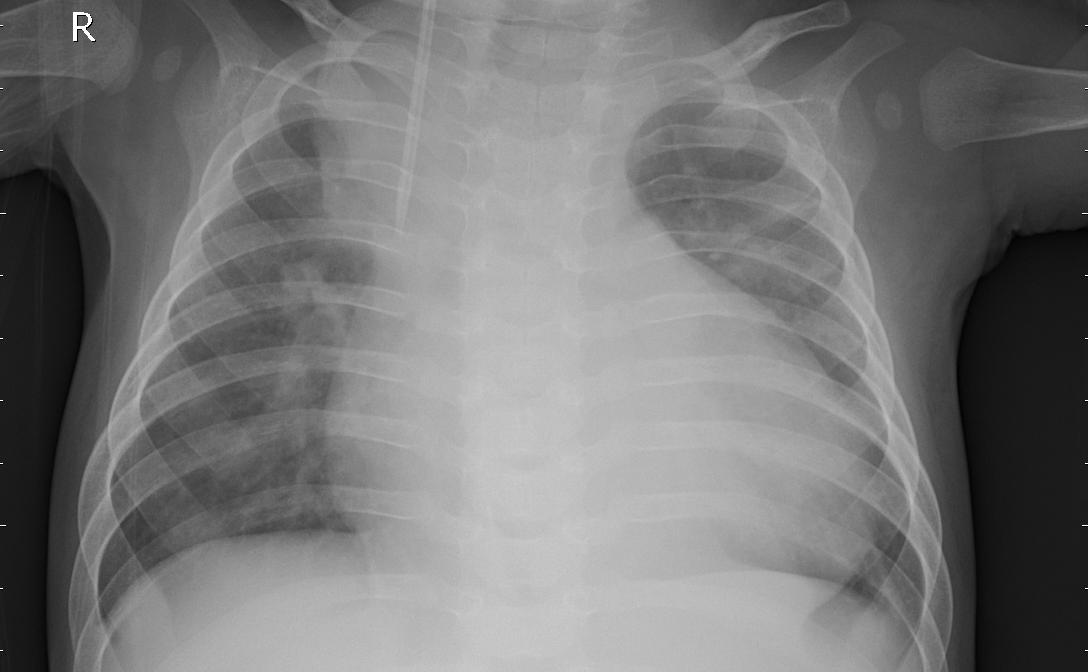

In [32]:
from IPython.display import Image
Image(file_name) 

In [33]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)

In [34]:
result

[0.3227519690990448, 0.6772480010986328]

In [37]:
index = np.argmax(result)
object_categories = ['normal','pneumonia']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - pneumonia, probability - 0.6772480010986328
